# 2. Quick Start
In this notebook, we’ll learn how to create a complete deep learning project in PyTorch. Broadly, a project consists of three main components:
 * Preparing the dataset and defining the task
 * Designing the architecture of the neural network
 * Implementing the training and testing routines
 
To keep things clear, we’ll work on a simple example where the network classifies basic geometric shapes (like circles, squares, and triangles) in images. This will help us focus on the main steps without overwhelming details.

## 0. Preparation

Before we dive into the project, let's start by preparing the necessary materials.

### Required Packages

We will use several Python libraries, each serving a specific role:

- **[numpy](https://numpy.org/):** The main library for scientific computing in Python, commonly imported as `np`.
- **[matplotlib](https://matplotlib.org/):** Useful for plotting graphs and visualising data.
- **[torch](https://pytorch.org/docs/stable/index.html):** The core library in PyTorch for deep learning, helping us define and manage neural networks.
- **[torchvision](https://pytorch.org/vision/stable/index.html):** Contains tools and datasets for computer vision tasks.
- **[cv2](https://docs.opencv.org/4.x/index.html) (OpenCV):** A widely-used library for image processing.

Let's import these libraries now:

In [6]:
# importing the necessary packages/libraries
import numpy as np
from matplotlib import pyplot as plt
import random

import torch
import torch.nn as nn
import torchvision

import cv2

Deep learning tasks can be computationally demanding. GPUs are often used because they are designed to handle complex calculations efficiently. In this case, if a **GPU** is available, PyTorch will use it; otherwise, it will default to using the **CPU**.

In [2]:
# Automatically selects GPU if available, else defaults to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Dataset 

In deep learning, it’s often practical to start by considering the dataset and task you’re working with. In many real-world projects, we already have a dataset that we load from disk. However, in this example, we’ll create a small dataset on the fly within the notebook.

We will create images containing one of three geometric shapes:
1. Circle
2. Ellipse
3. Rectangle

Each image will contain only one shape on a background, and our task is to classify the shape in each image. This task is known as **image classification**.

In [3]:
# Define the labels for our shapes
labels_map = {
    0: "circle",
    1: "ellipse",
    2: "rectangle"
}

### Dataset Utility Functions

We’ll now write helper functions to generate our dataset. Specifically, we’ll create two functions:
* `create_random_background`: This function will generate a background for each image.
* `create_random_shape`: This function will add a shape to the background.

Let’s look at each function in detail.

In [7]:
def create_random_background(img_size, p=0.5):
    """
    Creates a background for an image. 
    
    Args:
        img_size (int): Size of the background (image will be square).
        p (float): Probability of generating a random noise background.
        
    Returns:
        numpy array: Background image of size (img_size, img_size, 3).
    """
    # If a randomly generated number is above p, create a noise background; otherwise, use a uniform colour
    if np.random.rand() > p:
        # Random noise background: random pixel values for each RGB channel
        return np.random.randint(0, 256, (img_size, img_size, 3), dtype='uint8')
    else:
        # Uniform background: same colour for each pixel
        return np.zeros((img_size, img_size, 3), dtype='uint8') + np.random.randint(0, 256, dtype='uint8')

- This function creates a random background for our image. Sometimes it’s just a uniform colour (like a single shade), while other times it’s a random noise background (each pixel has a random colour).
- By creating different types of backgrounds, we introduce some **variation** to make the task slightly more challenging.

In [8]:
def create_random_shape(img, filled):
    """
    Draws a random shape (circle, ellipse, or rectangle) on the given background image.
    
    Args:
        img (numpy array): Background image on which to draw the shape.
        filled (bool): If True, shapes will be filled; otherwise, they will be outlined.
    
    Returns:
        tuple: Modified image with shape and shape label (int).
    """
    # Generate a random colour for the shape
    colour = [random.randint(0, 255) for _ in range(3)]
    thickness = np.random.randint(2, 7)
    point1 = np.random.randint(img.shape[0] // 4, 3 * (img.shape[0] // 4), 2)

    # Select a random shape (circle, ellipse, or rectangle)
    shape_ind = np.random.randint(0, len(labels_map))
    # Set shape to be filled if `filled` is True
    thickness *= -1 if filled else np.random.choice([-1, 1])

    if shape_ind == 0:  # Circle
        radius = np.random.randint(10, img.shape[0] // 4)
        img = cv2.circle(img, tuple(point1), radius, color=colour, thickness=thickness)
    elif shape_ind == 1:  # Ellipse
        axes = [np.random.randint(10, 20), np.random.randint(30, img.shape[0] // 4)]
        angle = np.random.randint(0, 360)
        img = cv2.ellipse(img, tuple(point1), axes, angle, 0, 360, color=colour, thickness=thickness)
    else:  # Rectangle
        point2 = np.random.randint(0, img.shape[0], 2)
        img = cv2.rectangle(img, tuple(point1), tuple(point2), color=colour, thickness=thickness)
    
    return img, shape_ind

- This function draws a randomly chosen shape on the background.
- `shape_ind` specifies which shape to draw (circle, ellipse, or rectangle), and `filled` determines whether the shape is filled or just outlined.
- The function returns both the modified image and the label of the shape (used later for training).

### Training and Testing Sets

We usually divide data into three parts: **training**, **validation**, and **testing**:
- **Training Set**: Used for learning.
- **Validation Set**: Used to fine-tune parameters.
- **Test Set**: Used to evaluate the model.

To ensure the model generalises well, a rule of thumb is 70% training, 15% validation, and 15% testing.
Validation data can be utilised for hyperparameter tuning, such as identifying the best optimiser algorithm and the optimal learning rate. The test set must never be used in any part of the training process.

![Dataset Split](https://blog.kakaocdn.net/dn/UenrJ/btrk6fXBfbJ/4iGSlrWj4mVJxzmup2KVr1/img.png)

In our case, we’ll create two sets of images: one for training and one for testing. We skipped the validation, because we're not doing any hyper parameter tunning.

In [9]:
def make_image_set(num_imgs, img_size, bg_p, filled):
    """
    Generates a dataset of images containing random shapes.
    
    Args:
        num_imgs (int): Number of images to create.
        img_size (int): Size of each image (square).
        bg_p (float): Probability of a uniform background.
        filled (bool): Whether shapes are filled or outlined.
    
    Returns:
        list: Images and corresponding shape labels.
    """
    imgs = []
    gts = []
    for _ in range(num_imgs):
        img = create_random_background(img_size, bg_p)
        img, gt = create_random_shape(img, filled)
        imgs.append(img)
        gts.append(gt)
    return imgs, gts

Here, `make_image_set` generates a set of images based on the specified number and size. 

**Note**: this functoins cannot be scaled to large datasets as it loads all images into a large list. For instance, if we want to have one million images, we run out of memory.

**Exercise:** Consider how this function could be modified to handle very large datasets.

Next, we create a trarin set of 1000 images and a test set of 100 images.

In [10]:
# Parameters for the dataset
img_size = 128  # Image size (128 x 128 pixels)
filled = True  # Choose whether shapes are filled or outlined
bg_uniform_vs_noise = 1  # Probability of uniform background

# Create training and test sets
number_trains = 1000  # Number of training images
number_test = number_trains // 10  # Number of test images

# Generate image datasets
train_imgs, train_gts = make_image_set(number_trains, img_size, bg_p=bg_uniform_vs_noise, filled=filled)
test_imgs, test_gts = make_image_set(number_test, img_size, bg_p=bg_uniform_vs_noise, filled=filled)

### Dataset Visualisation

Let's look at a sample of our generated images to verify they appear as expected. Using `plt` from `matplotlib`, we’ll create a grid of images with their corresponding shape label (ground truth).

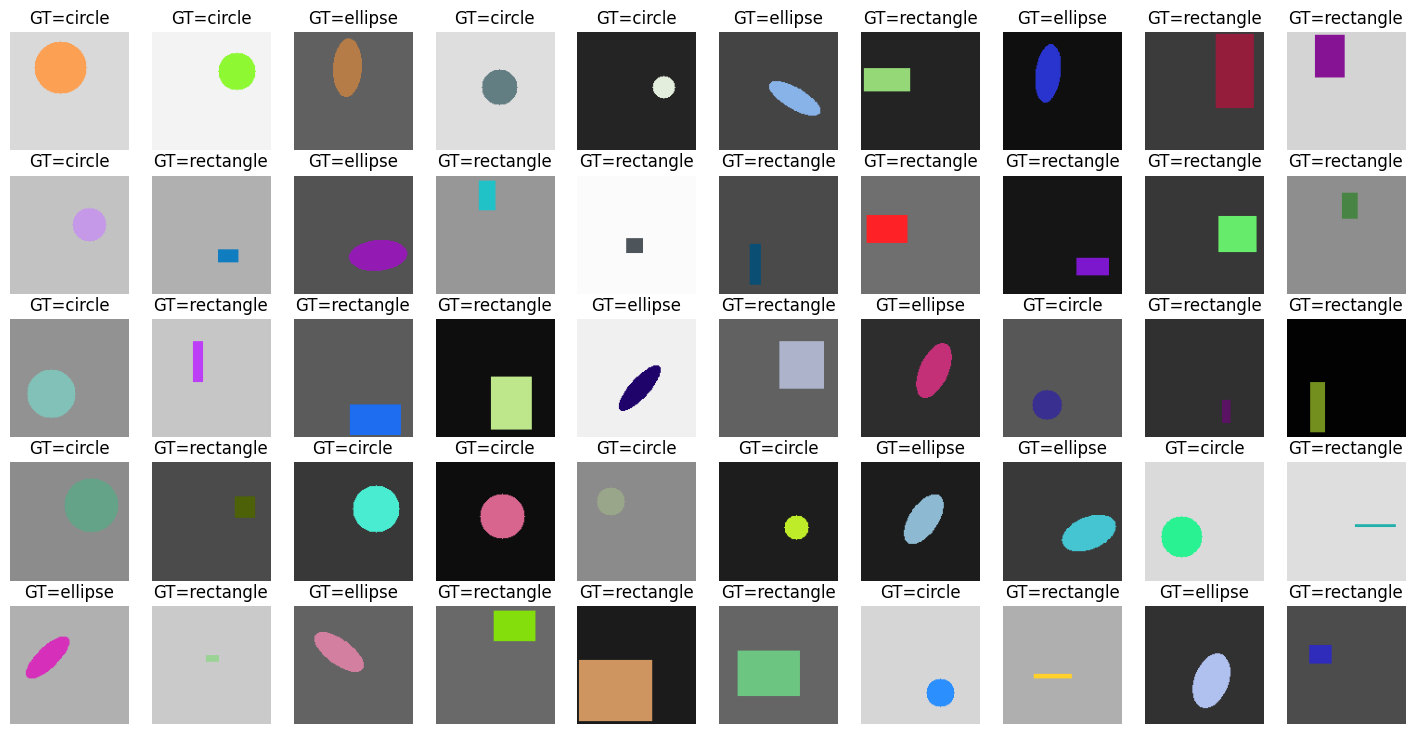

In [12]:
# plot 50 of the images
fig = plt.figure(figsize=(18, 9))
for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.imshow(train_imgs[i])
    ax.axis('off')
    ax.set_title('GT=%s' % labels_map[train_gts[i]])

### PyTorch Data Pipeline

Now that we have created our dataset, we need to create **PyTorch dataloaders** to efficiently manage and load our data during model training and evaluation. PyTorch dataloaders make it easier to handle large datasets by loading small batches of data sequentially, which is essential for efficient memory usage and faster processing.

In this example, we define a custom dataloader class, `ShapeDataset`, by inheriting from `torch.utils.data.Dataset`. Custom datasets in PyTorch should implement two main functions:

1. **`__len__`**: Returns the number of samples in the dataset.
2. **`__getitem__`**: Retrieves a specific sample from the dataset, based on the provided index.

In deep learning, datasets are often very large (for example, ImageNet contains 1.5 million images). Loading all images into memory at once would require a vast amount of memory, so instead, we load each image dynamically within the `__getitem__` function. This approach helps us manage memory effectively, especially when working with limited computational resources.

With this structure, you can customise datasets for any purpose by creating similar classes with a defined initialisation (`__init__`), length (`__len__`), and retrieval (`__getitem__`) functionality.

In [15]:
# PyTorch Dataset Class for Shape Data
class ShapeDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, gts, transform=None):
        """
        Initialise the dataset with images, ground-truth labels, and optional transformations.
        
        Args:
            imgs (list or array): List of images.
            gts (list or array): Ground-truth labels associated with each image.
            transform (callable, optional): Transformations to be applied to each image.
        """
        self.imgs = imgs        # Store images
        self.gts = gts          # Store ground-truth labels
        self.transform = transform  # Store transformations (if any)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.imgs)

    def __getitem__(self, idx):
        """
        Retrieves a sample and its ground-truth label by index.
        
        Args:
            idx (int): Index of the sample.
        
        Returns:
            tuple: Transformed image and its corresponding ground-truth label.
        """
        # Get image and label for the given index
        img = self.imgs[idx]
        gt = self.gts[idx]  # gt = ground truth, representing the shape's ID here

        # Apply transformation if specified
        if self.transform:
            img = self.transform(img)

        # Return the image and its label as a tuple
        return img, gt

- **Initialisation (`__init__`)**: This function sets up the dataset. It typically receives and stores all the necessary data (e.g., `imgs` for images, `gts` for ground-truth labels). It also takes in a `transform` parameter to allow for optional transformations on each sample. In practice, only paths to the images might be loaded, while the actual image data is loaded dynamically in `__getitem__`.
  
- **Data Transformations (`transform`)**: Transformations are critical in deep learning workflows to ensure data is processed consistently and to improve model performance by applying operations such as normalisation and data augmentation. Let’s discuss transformations in more detail.

### Data Transformations

In this example, we use two standard transformations:

1. **`ToTensor`**: Converts an image into a PyTorch tensor. PyTorch models work with tensors, so we must apply this transformation before feeding data into our model.
  
2. **`Normalize`**: Scales image pixel values so they are centred around zero. This is important because many deep learning models perform better when the data has a mean of zero and a standard deviation close to one. We specify the `mean` and `std` values for normalisation, tailored to our dataset.

Transformations are applied sequentially using `torchvision.transforms.Compose`, which allows chaining multiple transformations together.

In [19]:
# Set mean and standard deviation for normalisation
mean = 0.5
std = 0.25

# Compose transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),               # Convert to tensor
    torchvision.transforms.Normalize(mean, std),     # Normalise with mean and std
])

### DataLoader: Managing Data Batches

`DataLoader` in PyTorch enables efficient batch processing, which is crucial for training and evaluation. Here are some important parameters for `DataLoader`:

- **`batch_size`**: Defines how many samples are processed in each batch. Processing in batches allows efficient use of GPU resources and is necessary for stochastic gradient descent (SGD).
  
- **`num_workers`**: Specifies the number of CPU threads to load and preprocess the data before sending it to the GPU. Using multiple workers can speed up data loading, especially with larger datasets.
  
- **`shuffle`**: Randomly shuffles the data at each epoch. This is usually set to `True` during training to prevent the model from learning the order of the data.

> **Note**: `batch_size` and `shuffle` settings can vary between training and testing. For example, we may set a larger `batch_size` and avoid shuffling during testing since we do not need to update model weights.

In [21]:
# Instantiate dataset for training
train_dataset = ShapeDataset(train_imgs, train_gts, transform=transform)

# Set batch size
batch_size = 8

# Create DataLoader for training
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True
)

# Instantiate dataset for validation
val_dataset = ShapeDataset(test_imgs, test_gts, transform=transform)

# Create DataLoader for validation
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True
)

## 2. Model

With our images generated and PyTorch dataloaders ready, we can now move on to building our neural network model.

Since our task is relatively straightforward, we don’t need a highly complex model. In this example, we define a simple convolutional neural network (CNN) that will perform well on basic image classification tasks. Our model will inherit from `torch.nn.Module`, a base class in PyTorch used for creating neural network models. Any model that inherits from this class must implement at least a `forward` function, which defines how data will pass through the network layers.

The `forward` function is automatically called whenever we pass data through the network. Here, it receives a batch of images, but it could take multiple inputs if needed, such as:

- Image pairs to check if they are similar
- Triple images to identify the one that differs from the others

### Architecture

In the `__init__` function, we set up our model’s architecture. This example (`SimpleNet`) consists of three main components:

1. **Feature Processing** (`self.features`): This part is made up of three convolutional blocks. Each block includes:
   - **Convolutional Layer**: Extracts features by applying filters to the input images.
   - **Batch Normalisation**: Stabilises training by normalising activations.
   - **ReLU Activation**: Introduces non-linearity, helping the model to learn complex patterns.
   - **Max Pooling**: Reduces the spatial dimensions (height and width), keeping the most important features.

2. **Global Average Pooling** (`self.avgpool`): This layer pools the features across the entire spatial resolution, producing a summary of each feature map.

3. **Classifier** (`self.classifier`): This fully connected (linear) layer maps the extracted features to the number of classes, providing the final predictions.

Let’s dive into the code to see how this structure is implemented.

In [22]:
# Define the Simple CNN Model
class SimpleNet(nn.Module):
    def __init__(self, num_classes: int) -> None:
        """
        Initialises the layers of the network.
        
        Args:
            num_classes (int): Number of output classes for classification.
        """
        super().__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Input channels=3 (RGB), Output channels=16
            nn.BatchNorm2d(16),                                    # Batch normalisation for 16 channels
            nn.ReLU(inplace=True),                                 # Activation function
            nn.MaxPool2d(kernel_size=3, stride=2),                 # Max pooling with 3x3 filter and stride of 2

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # Increase channels to 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Further increase channels to 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        # Global average pooling to reduce spatial dimensions to 1x1
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classification layer (fully connected layer)
        # Input size is 64, as it matches the output channels of the last convolution layer
        self.classifier = nn.Linear(1 * 1 * 64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass through the network.
        
        Args:
            x (torch.Tensor): Input batch of images.
        
        Returns:
            torch.Tensor: Output predictions for each input image.
        """
        # Pass the input through the feature extraction layers
        x = self.features(x)
        
        # Apply global average pooling
        x = self.avgpool(x)
        
        # Flatten the output from the feature extraction to 1D (required by classifier)
        x = torch.flatten(x, 1)
        
        # Pass through the classification layer to get the final output
        x = self.classifier(x)
        
        return x

Explanation of Key Components:

1. **Feature Extraction Layers (`self.features`)**: Each convolutional block in `self.features` extracts increasingly complex patterns from the images. The convolutional layers increase the depth (number of channels) of the feature maps from 3 (RGB channels) to 16, 32, and finally 64. Batch normalisation stabilises the activations, and ReLU introduces non-linearities that help the model learn complex features.

2. **Global Average Pooling (`self.avgpool`)**: By reducing the feature maps to a single value per channel, global average pooling summarises the features and allows the classifier to operate on a fixed-size input, regardless of the image dimensions.

3. **Fully Connected Layer (`self.classifier`)**: This layer maps the processed features to the number of classes, producing the final predictions. Here, `num_classes` represents the number of categories we want to classify.

### Network
Now that we’ve defined the model architecture, we’ll create an instance of `SimpleNet`, specifying the number of output classes. We then move the model to the GPU for faster computation if available, and print out the model’s structure to verify.

In [26]:
# Instantiate the model
model = SimpleNet(num_classes=len(labels_map))

# Move the model to the GPU if available
model = model.to(device)

# Print the model architecture to review
print(model)

SimpleNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Linear(in_features=64, out_features=3, bias=True)
)


## 3. Training and Testing Routines

Now that we’ve prepared our dataset and built our model, it’s time to start training and evaluating our neural network. This section explains each component of the training process, including optimisation, loss calculation, and accuracy evaluation.

### Optimiser

The optimiser is responsible for updating the model's parameters to minimise the loss during training. When defining an optimiser, we choose which parameters to optimise, the optimisation algorithm, and a key parameter called the **learning rate**. The learning rate controls how much to adjust the model's parameters with each step.

In our case, we use **Stochastic Gradient Descent (SGD)** with parameters for `momentum`, `learning_rate`, and `weight_decay`. Each plays an important role:

- **Learning Rate**: Controls the step size in each update; too large a value might skip over optimal values, and too small a value could result in slow learning.
- **Momentum**: Helps accelerate gradients to optimise faster and avoid oscillations.
- **Weight Decay**: Adds a penalty to large weights to prevent overfitting.

![learning-rate](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

In [27]:
# Define optimiser and criterion
params_to_optimise = [{'params': [p for p in model.parameters()]}]
momentum = 0.9
learning_rate = 0.01
weight_decay = 1e-4

# Initialising the SGD optimiser with specified parameters
optimiser = torch.optim.SGD(
    params=params_to_optimise,
    lr=learning_rate,
    momentum=momentum,
    weight_decay=weight_decay
)

### Loss Function

The **loss function** quantifies how well the model’s predictions match the ground truth. In this example, we use **categorical cross-entropy** (`nn.CrossEntropyLoss`) as our loss function, which is well-suited for classification tasks where the goal is to correctly categorise inputs into discrete classes (like recognising different shapes).

We can consider the learning paradigm in this example to be **semi-supervised**. The ground-truth labels for our shapes were not manually annotated by humans. Instead, we automatically generated these labels using mathematical equations to define the geometrical shapes. This approach allowed us to skip the laborious process of manually labelling each image, providing labelled data in a more efficient way.

In [28]:
# Initialise the loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss().to(device)

### Training-testing Utility Functions

To evaluate model performance, we use an `accuracy` function that calculates how many predictions match the ground truth.

In [29]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the top k predictions.
    
    Args:
        output (torch.Tensor): Model predictions.
        target (torch.Tensor): Ground truth labels.
        topk (tuple): Top k values to compute accuracy for.
    
    Returns:
        List of accuracies for specified top k values.
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)Executing the Programme

        # Get top k predictions
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

To train and evaluate our model, we define a utility function called `epoch_loop`, which performs the operations required in each epoch. An **epoch** refers to one complete pass through the entire dataset—essentially, processing all samples in the dataset once.

Since much of the code for training and testing is similar, it’s efficient to combine both procedures into a single function. The parts that differ for training and testing can be separated within the function using conditional statements. For example, during training, we need to perform additional steps to update the model’s parameters:

1. **Compute the Gradient**: We reset the gradients with `optimizer.zero_grad()`, ensuring that previous gradients do not interfere with the current update.
2. **Backpropagate the Loss**: We calculate the gradients with `loss.backward()`, which backpropagates the loss to update each parameter in the network.
3. **Optimise the Weights**: Finally, `optimizer.step()` adjusts the weights based on the computed gradients, helping the model learn from the errors.

<font color='red'>**Important**</font>: When evaluating (or testing) a model, it’s essential to call the `.eval()` method. This prevents certain layers (like dropout or batch normalisation) from updating, ensuring a consistent evaluation.

<font color='red'>**Important**</font>: Also, use `torch.set_grad_enabled()` to specify whether gradients should be calculated (`True` during training and `False` during testing).

In [30]:
def epoch_loop(model, db_loader, criterion, optimiser=None):
    """
    Run a single epoch for training or testing.
    
    Args:
        model (torch.nn.Module): The model to train/test.
        db_loader (DataLoader): Data loader for training or testing data.
        criterion (Loss Function): Loss function for computing the error.
        optimiser (torch.optim.Optimizer): Optimiser for training; if None, evaluation mode is assumed.
        
    Returns:
        accuracies (list): List of accuracies for each batch.
        losses (list): List of losses for each batch.
    """
    # Determine whether in training mode
    is_train = optimiser is not None
    model.train() if is_train else model.eval()
    
    accuracies = []
    losses = []
    
    # Disable gradient computation for evaluation
    with torch.set_grad_enabled(is_train):
        for batch_ind, (img, target) in enumerate(db_loader):
            # Move images and targets to device (GPU or CPU)
            img = img.to(device)
            target = target.to(device)
            
            # Forward pass: compute output and loss
            output = model(img)
            loss = criterion(output, target)
            losses.extend([loss.item() for _ in range(img.size(0))])

            # Compute accuracy
            acc = accuracy(output, target)[0].cpu().numpy()
            accuracies.extend([acc[0] for _ in range(img.size(0))])
            
            # Backward pass and optimisation step for training
            if is_train:
                optimiser.zero_grad()   # Reset gradients
                loss.backward()         # Backpropagate loss
                optimiser.step()        # Update parameters
    
    return accuracies, losses

## 4. Actual Learning

With all components set up (data, model, loss, and optimiser), we can start the training and testing loop. In this example, we train the model for 10 epochs, meaning the model will go through all data points 10 times.

In [32]:
# Set the number of epochs for training
epochs = 10
initial_epoch = 0

# Logs for tracking accuracy and loss over time
train_logs = {'acc': [], 'loss': []}
val_logs = {'acc': [], 'loss': []}

for epoch in range(initial_epoch, epochs):
    # Run a training epoch
    train_log = epoch_loop(model, train_loader, criterion, optimiser)
    
    # Run a validation epoch (no optimiser, so the model is in evaluation mode)
    val_log = epoch_loop(model, val_loader, criterion, optimiser=None)
    
    # Print training and validation results for this epoch
    print('[Epoch %02d] Train loss=%.4f, acc=%.2f  |  Test loss=%.4f, acc=%.2f' % 
          (
              epoch, 
              np.mean(train_log[1]), np.mean(train_log[0]),
              np.mean(val_log[1]), np.mean(val_log[0])
          ))
    
    # Log the results for plotting later
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))

[Epoch 00] Train loss=1.0931, acc=42.50  |  Test loss=1.5249, acc=39.00
[Epoch 01] Train loss=0.9635, acc=52.00  |  Test loss=1.8905, acc=46.00
[Epoch 02] Train loss=0.9573, acc=53.20  |  Test loss=0.8564, acc=60.00
[Epoch 03] Train loss=0.8676, acc=54.40  |  Test loss=0.8282, acc=63.00
[Epoch 04] Train loss=0.7738, acc=60.30  |  Test loss=0.7517, acc=57.00
[Epoch 05] Train loss=0.8479, acc=57.40  |  Test loss=0.9288, acc=54.00
[Epoch 06] Train loss=0.7364, acc=60.50  |  Test loss=0.7228, acc=56.00
[Epoch 07] Train loss=0.6657, acc=62.00  |  Test loss=0.6452, acc=59.00
[Epoch 08] Train loss=0.5996, acc=65.50  |  Test loss=0.5780, acc=71.00
[Epoch 09] Train loss=0.5852, acc=65.80  |  Test loss=0.5408, acc=70.00


## 5. Reporting Results

Finally, we’ll plot the accuracy and loss over the training epochs to evaluate the model’s performance. These plots can reveal if the model is improving over time or if adjustments are needed to hyperparameters.

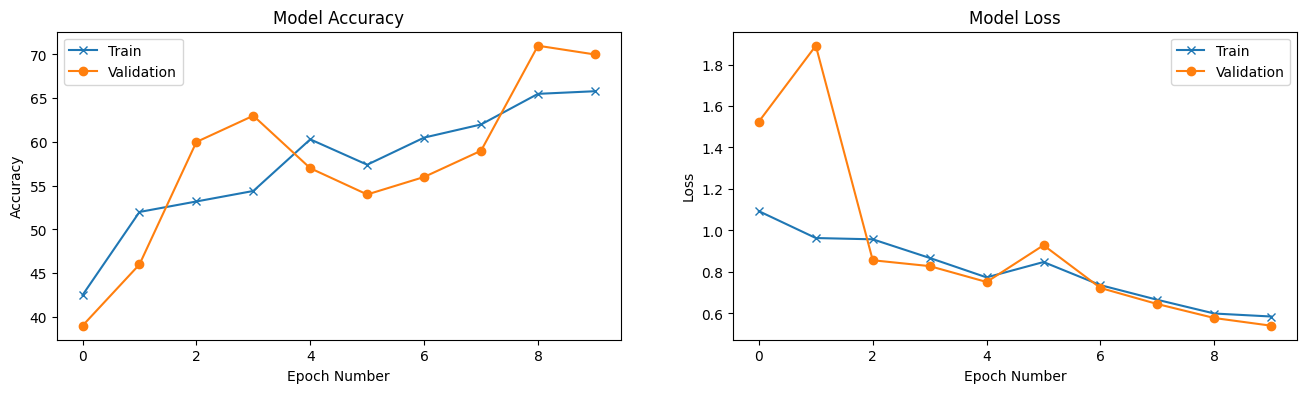

In [39]:
# Plot accuracy and loss over epochs
fig = plt.figure(figsize=(16, 4))

# Plot accuracy
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_logs['acc'], '-x', label='Train')
ax.plot(val_logs['acc'], '-o', label='Validation')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Accuracy')
ax.legend()

# Plot loss
ax = fig.add_subplot(1, 2, 2)
ax.plot(train_logs['loss'], '-x', label='Train')
ax.plot(val_logs['loss'], '-o', label='Validation')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

## Exercises

These exercises are designed to help you extend and test the concepts covered in this chapter. Each exercise challenges you to apply your knowledge to adjust the data handling, background properties, and shape complexity of the dataset.

### 1. Implementing a Dataloader to Load Images from Disk

As discussed, we generally cannot load all images into memory due to limitations, especially when working with large datasets. 

**Objective**: Modify the code to load images on the fly from a specified directory structure.

1. Download this [zip file](https://www.dropbox.com/s/rltbecab0zx1zep/shape_set.zip?dl=0) and extract it. The directory contains:
    - Two subfolders: `train` and `test`, holding the training and test images, respectively.
    - Two CSV files with ground truth labels for the images in `train` and `test`.

2. Update the dataloader to accept a directory path as an argument. 

3. Instead of loading all images at once, adjust the `__getitem__` function in your `Dataset` class to load each image directly from disk. This function should read each image and return it with its associated label.

This approach enables efficient memory usage and prepares you to work with real-world datasets that cannot fit into memory.

### 2. Exploring the Effect of Background Colour in Training and Testing

In this exercise, you will experiment with the background colour of images in the training and test sets. By changing background properties, you can investigate how well the model generalises under different conditions.

1. **Achromatic vs Colourful Backgrounds**:
   - Update the dataloader to accept an argument specifying the type of background (achromatic or colourful).
   - For the training set, use only **achromatic (greyscale) backgrounds**.
   - For the test set, use **colourful backgrounds**.
   - Train the model and observe if it can generalise to images with colourful backgrounds in the test set.

2. **Swap Background Colours**:
   - Switch the backgrounds so that the training set has **colourful backgrounds** and the test set has **greyscale backgrounds**.
   - Observe how this impacts the model’s performance.

3. **Experiments with Foreground Colours**:
   - Conduct similar experiments by modifying the colours of the foreground shapes instead of the background. 

**Bonus**: If the model struggles to learn the task with these manipulations, experiment with additional training epochs, or modify the network architecture to improve test accuracy. This challenge will help you understand how to tune model complexity and training duration for more complex tasks.

### 3. Adding New Geometrical Shapes to the Dataset

Our current dataset contains only three types of geometrical shapes. This exercise involves expanding the dataset by adding one or more new shapes, such as squares or triangles.

1. Modify the data generation function to add at least one new shape.
2. Visualise a few examples of your updated dataset to confirm the new shapes are included.
3. Update the network and training code to accommodate the expanded set of classes, then train the model with the new dataset. 

By extending the dataset, you’ll learn how to adapt your data generation and model design to recognise an increased number of classes. This is useful practice for scaling models to handle more complex data.